<a name="top" id="top"></a>

<div align="center">
    <h1>Module 1: EDA and Basic Engineering</h1>
    <i>Jakub Opala</i>

</div>

First let's load the data and take a look at first few rows.

In [71]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
import seaborn as sns
import requests
import warnings
import miceforest as mf
from miceforest import ImputationKernel
from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer



path = 'data/bank-additional-full.csv'
url = 'https://static.cdn.epam.com/uploads/583f9e4a37492715074c531dbd5abad2/ds_test/eda/data.zip'
#dataset = requests.get(url)

#data = pd.read_csv('https://static.cdn.epam.com/uploads/583f9e4a37492715074c531dbd5abad2/ds_test/eda/data.zip/bank-additional-full.csv')

#with open("/content/streeteasy.csv", "w+") as file:
#    file.write(dataset.content.decode("utf-8"))

data = pd.read_csv(path,sep=';')
data.drop_duplicates(inplace=True)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Lets check what values we have in each column:

In [72]:
columns = data.columns.tolist()
for column in columns:
    print(column, ':    ', data[column].unique())#[:20])

age :     [56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]
job :     ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital :     ['married' 'single' 'divorced' 'unknown']
education :     ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default :     ['no' 'unknown' 'yes']
housing :     ['no' 'yes' 'unknown']
loan :     ['no' 'yes' 'unknown']
contact :     ['telephone' 'cellular']
month :     ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week :     ['mon' 'tue' 'wed' 'thu' 'fri']
duration :     [ 261  149  226 ... 1246 1556 1868]
campaign :     [ 1  2  3  4  5  6  7  8  9 10 11 12 13 19 18 23 14 22 25 16 17 15 

Using information concering the dataset we can already see that for a training purposes we dont want to use duration feature as it is not available before making a call anyway. Also we need to take care of the fact that in pdays we have values 999 where client wasnt previously contacted. Obviously it will have huge impact on this feature so we might for example add additonal binary feature describing if the client was contacted before.

We can see also that there is no data from january and february.

We can also replace values in 'y' column no,yes -> 0,1.

In [73]:
data.drop(columns='duration', inplace=True)
data['y'] = (data['y'] == 'yes').astype(int)

data['contacted'] = (data['pdays'] != 999).astype(int)
column_to_move = 'contacted'  
columns = list(data.columns)
columns.insert(3, columns.pop(columns.index(column_to_move)))
data = data[columns]
#data.isna().sum()
#data.replace(0, np.NaN).isna().sum()

In [74]:
print('contacted clients: ', data[data['pdays'] != 999].shape[0])
print('not contacted clients: ', data[data['pdays'] == 999].shape[0])

cols = ['y','pdays','contacted']
corr_matrix = data[cols].corr()
corr_matrix["y"].sort_values(ascending=False)


contacted clients:  1515
not contacted clients:  39661


y            1.000000
contacted    0.324910
pdays       -0.324948
Name: y, dtype: float64

We can see that number of not contacted clients is much bigger than of those who were contacted. Correlation between the target and pdays is almost identical (apart from the sign beacuse of course) as between the target and out new column contacted. It leads us to a conclusion that we can just replace pdays column with value 1 if client was contacted and 0 otherwise (pdays == 999)

In [75]:
data.drop(columns='pdays', inplace=True)

In [76]:
#data.dtypes
categorical_columns = data.select_dtypes(include=['int32','object', 'category']).columns.to_numpy()
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.to_numpy()
categorical_columns = categorical_columns[categorical_columns != 'y']
print(categorical_columns)
print(numerical_columns)

['job' 'marital' 'contacted' 'education' 'default' 'housing' 'loan'
 'contact' 'month' 'day_of_week' 'poutcome']
['age' 'campaign' 'previous' 'emp.var.rate' 'cons.price.idx'
 'cons.conf.idx' 'euribor3m' 'nr.employed']


# Part 1: EDA

## <p style="font-size:30px">1. Univariate analysis: consider features separately, their distribution, descriptive statistics, anomalies, omissions, etc.</p> 

Histograms of categorical features:

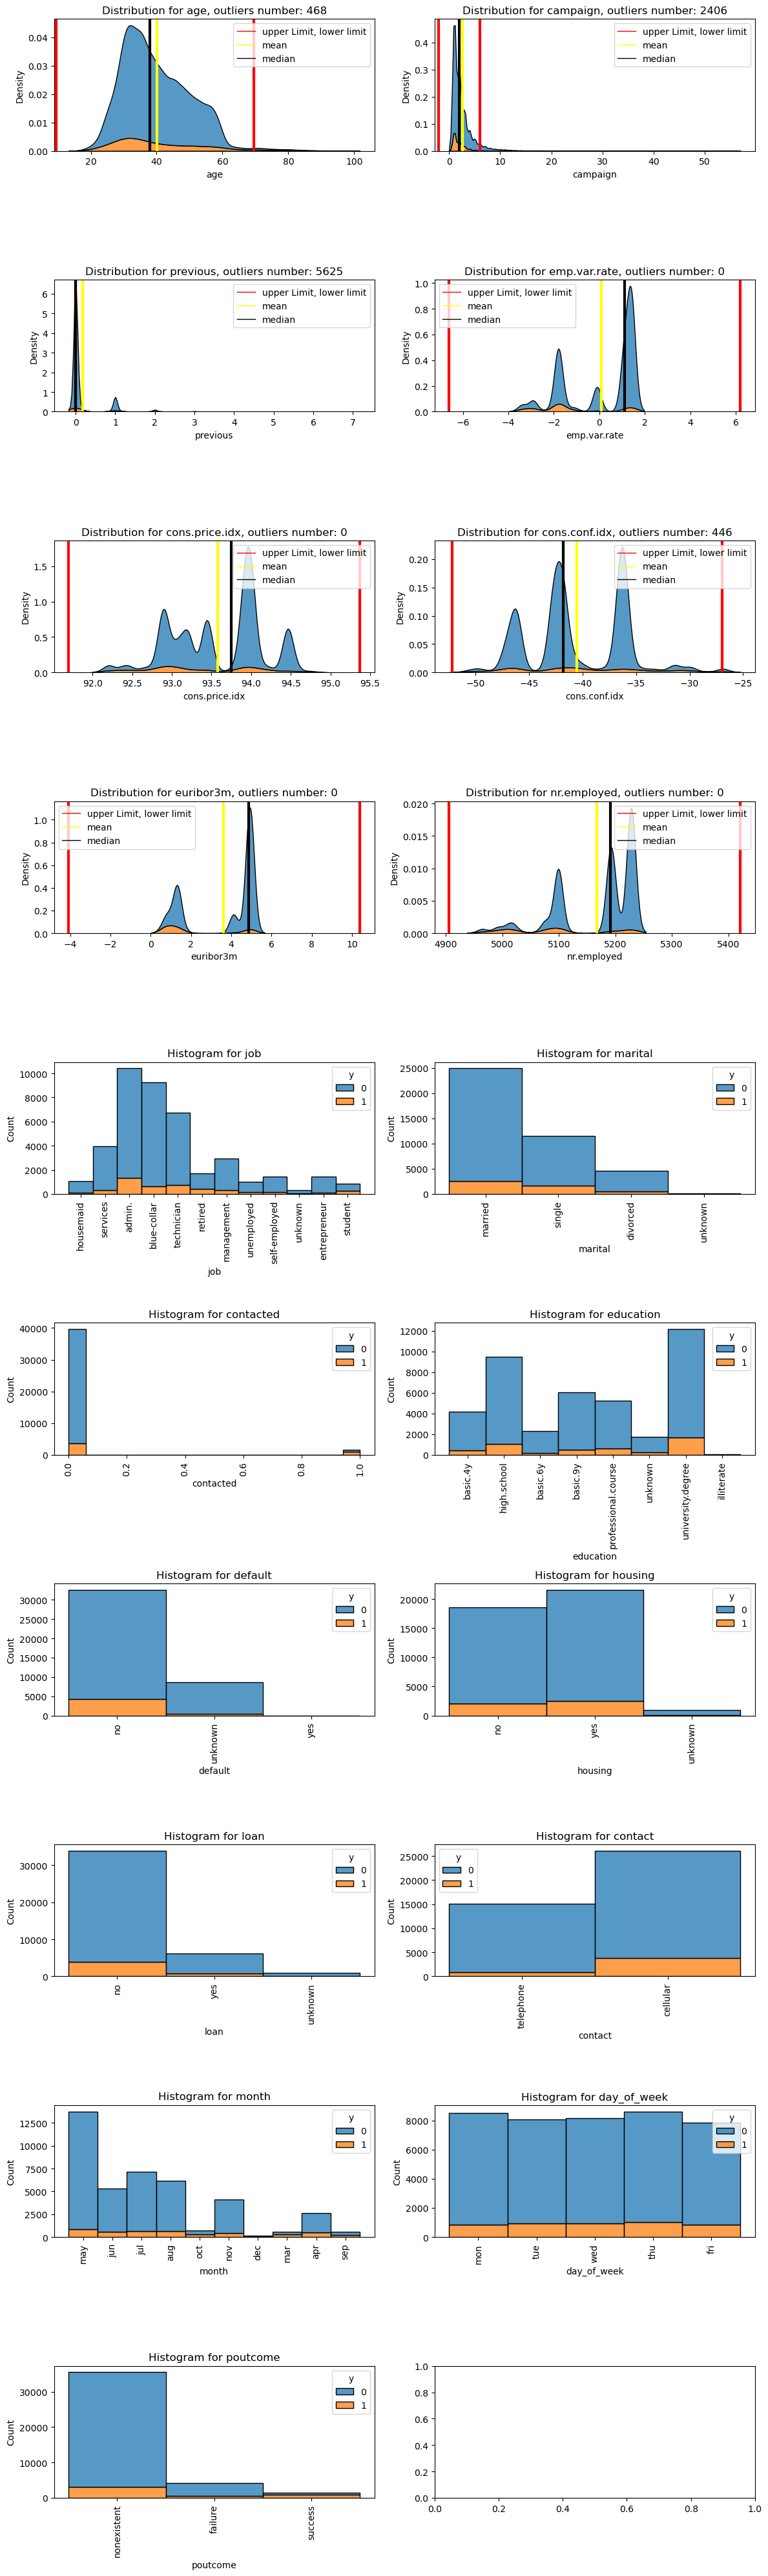

In [77]:
warnings.filterwarnings("ignore", category=FutureWarning)

fig, ax = plt.subplots(nrows=(len(data.columns.tolist()))//2,ncols=2,figsize=(12,40))

cols = np.concatenate((numerical_columns,categorical_columns), axis=None)

for i, column in enumerate(cols):#(data.columns.tolist()):

    row = i // 2
    col = i % 2



    #sns.histplot(data=data, x=column, hue='y', multiple='stack', ax=ax[row,col])
    #ax[row,col].set_title(f'Histogram for {column}')

    if column in categorical_columns or column == 'contacted':
        #sns.barplot(data=data, x=column, y='y', estimator='count', ax=ax[row,col])
        sns.histplot(data=data, x=column, hue='y', multiple='stack', ax=ax[row,col])
        ax[row,col].set_title(f'Histogram for {column}')
        ax[row,col].tick_params(axis='x', rotation=90)
    elif column in numerical_columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        #limits:
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        #outliers = data[column][(Q1 - 1.5 * IQR >= data[column]) |  (data[column] >= Q3 + 1.5 * IQR)].count()
        outliers = data[column][data[column] < Q1 - 1.5 * IQR].count() + data[column][data[column] > Q3 + 1.5 * IQR].count()
        #data = data[(data[column] >= lower_limit) & (data[column] <= upper_limit)]
        #data = data[data[column] >= lower_limit]
        sns.kdeplot(data=data, x=column, hue='y', multiple='stack', ax=ax[row,col])
        #sns.histplot(data=data, x=column, hue='y', multiple='stack', ax=ax[row,col])
        ax[row,col].set_title(f'Distribution for {column}, outliers number: {outliers}')

        ax[row,col].axvline(upper_limit, linewidth=3 , color="red")
        ax[row,col].axvline(lower_limit, linewidth=3 , color="red")
        ax[row,col].axvline(data[column].mean(), linewidth=3 , color="yellow")
        ax[row,col].axvline(data[column].median(), linewidth=3 , color="black")

        limits = mlines.Line2D([], [], color="red", linewidth=1, label="upper Limit, lower limit")
        mean = mlines.Line2D([], [], color="yellow", linewidth=1, label="mean")
        median = mlines.Line2D([], [], color="black", linewidth=1, label="median")
        ax[row,col].legend(handles=[limits, mean, median])
    
plt.tight_layout()
plt.show()

Ok so we can see a few things from those data:
<br>
 - Firstly there is much more instances with y equal to 0 (originally 'no') than with 1 ('yes'). Thats important info if we want to     optimally sample training data.
<br>
 - Distribution of in the rows with target value 1 is quite similar to distribution in the rows with target value 0. 
<br>
 - 'poutcome' class has huge number of missing values (nonexistent). It might be a good idea to completely get rid of it.
<br>
 - 'default' class doesn't bring much information as 75% values are 'no' and the rest is 'unknown' (apart from 3 'yes' values).

In [78]:
count_0 = data[data['contacted'] == 0]['poutcome'].value_counts()
count_1 = data[data['contacted'] == 1]['poutcome'].value_counts()
print('not contacted:  ',count_0)
print('contacted:  ',count_1)

not contacted:   poutcome
nonexistent    35551
failure         4110
Name: count, dtype: int64
contacted:   poutcome
success    1373
failure     142
Name: count, dtype: int64


In [79]:
data.drop(columns='poutcome', inplace=True)
categorical_columns = categorical_columns[categorical_columns != 'poutcome']

We can also remove outliers from out data using MAD method. It helps with removing outliers but opposed to quantile based methods it doesnt depend on the number of datapoints so we wont make unnecessary deletions of data. In this approach we calculate MAD which is a median of |$x_{i}$ - $\bar{x}$| and then calculate Z-score for each point in dataset: $$M = \frac{0.6745* (x_{i} - \bar{x})}{MAD}$$ Then we simply set some Z-score threshold and reject all datapoints that exceed those threshold.

In [80]:
for column in numerical_columns:

    MAD = np.median(np.abs(data[column] - data[column].mean()))
    data['M'] = 0.6745 / MAD * (data[column] - data[column].mean())
    Z_score_threshold = 3.5
    outliers = data['M'][data['M'] > 3.5].count()
    print(outliers, ' outliers in ', column)
    data = data[data['M'] <= Z_score_threshold]
    if column != 'age':
        data.drop(columns='M', inplace=True)

'''
for column in numerical_columns:
    
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    data = data[(data[column] >= lower_limit) & (data[column] <= upper_limit)]
    #data = data[data[column] >= lower_limit]
'''

99  outliers in  age
869  outliers in  campaign
1040  outliers in  previous
0  outliers in  emp.var.rate
0  outliers in  cons.price.idx
0  outliers in  cons.conf.idx
0  outliers in  euribor3m
0  outliers in  nr.employed


'\nfor column in numerical_columns:\n    \n    Q1 = data[column].quantile(0.25)\n    Q3 = data[column].quantile(0.75)\n    IQR = Q3 - Q1\n\n    lower_limit = Q1 - 1.5 * IQR\n    upper_limit = Q3 + 1.5 * IQR\n\n    data = data[(data[column] >= lower_limit) & (data[column] <= upper_limit)]\n    #data = data[data[column] >= lower_limit]\n'

We removed almost 2000 instances just by analysing 'campaign' and 'previous' features. It is quite a lot considering the size of our dataset but on the other hand these categories were extremely unbalanced. Good news is that other numerical features are fairly balanced.
We decided to leave 'age' outliers because it is quite natural statistic.
<br>
<br>
Now lets check statistics of numerical data

In [81]:
data.describe()#(include='all')

,age,contacted,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,39168.000000,39168.000000,39168.000000,39168.000000,39168.000000,39168.000000,39168.000000,39168.000000,39168.000000,39168.000000
mean,39.873136,0.021855,2.285309,0.115860,0.118814,93.570463,-40.546704,3.675518,5170.284541,0.103196
std,10.054203,0.146210,1.728079,0.320061,1.552690,0.571846,4.570192,1.703423,68.613416,0.304219
min,17.000000,0.000000,1.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.000000,0.000000,1.000000,0.000000,-1.800000,93.075000,-42.700000,1.365000,5099.100000,0.000000
50%,38.000000,0.000000,2.000000,0.000000,1.100000,93.444000,-41.800000,4.857000,5191.000000,0.000000
75%,47.000000,0.000000,3.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,81.000000,1.000000,10.000000,1.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


Okay, it looks rather good. We can see that most of the subjects are below age of 47. It is also visible that most of subjects were not contacted before. Similarilly most of value in 'previous' column are 0. We can see that scales of our data are very different so we will need to address this issue.

Okay now lets take a look at the 'unknown' values in some columns. How many of them is there? We will take care of them later.

In [82]:
cols = ['default','marital','loan','job','education','housing']
for col in cols:
    print('missing data in ', col, ': ', data[data[col] == 'unknown'].shape[0])

missing data in  default :  8295
missing data in  marital :  72
missing data in  loan :  939
missing data in  job :  309
missing data in  education :  1601
missing data in  housing :  939


## <p style="font-size:30px"> 2. Multivariate analysis: consider features in pairs, try to introduce new features to consider their relationship with other features, correlation</p> 

First, lets inspect numerical values and plot correlation matrix of numerical features as a heatmap:

[[ 1.    0.    0.    0.02  0.01  0.13  0.03  0.01  0.01]
 [ 0.    1.   -0.07  0.12  0.09 -0.01  0.1   0.11 -0.05]
 [ 0.   -0.07  1.   -0.43 -0.33 -0.14 -0.43 -0.42  0.13]
 [ 0.02  0.12 -0.43  1.    0.8   0.24  0.97  0.92 -0.28]
 [ 0.01  0.09 -0.33  0.8   1.    0.1   0.73  0.58 -0.15]
 [ 0.13 -0.01 -0.14  0.24  0.1   1.    0.32  0.13  0.04]
 [ 0.03  0.1  -0.43  0.97  0.73  0.32  1.    0.95 -0.28]
 [ 0.01  0.11 -0.42  0.92  0.58  0.13  0.95  1.   -0.31]
 [ 0.01 -0.05  0.13 -0.28 -0.15  0.04 -0.28 -0.31  1.  ]]


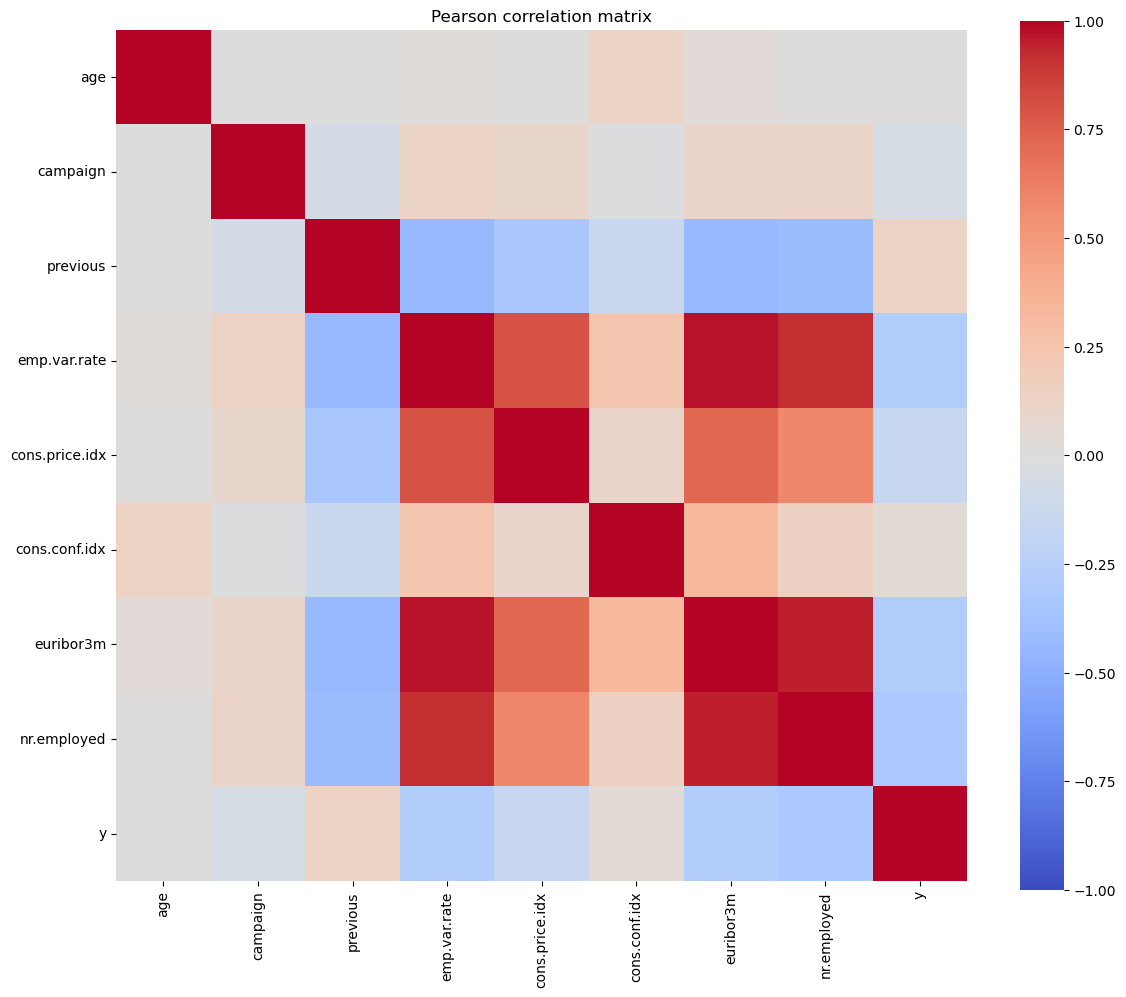

In [83]:
#data[numerical_columns].corr()['y'].sort_values(ascending=False)

#corr_matrix = data[numerical_columns].corr()
#corr_matrix["y"].sort_values(ascending=False)
plt.figure(figsize=(12, 10))
cor = data[list(numerical_columns) +['y']].corr()
sns.heatmap(cor, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f", square=True)
plt.title("Pearson correlation matrix")
plt.tight_layout()
#plt.show()
print(np.round(cor.to_numpy(), 2))

#data.hist(figsize=(12,8))
#sns.boxplot( data=data)
#sns.pairplot(data)
#pd.plotting.scatter_matrix(data, figsize=(12,8))

We can see that age, campgain and cons.cond.idx don't seem to be much of a help. Their correlation with the target is very close to 0. Okay but the relation between them might just not be linear. We'll check that later.
<br>
<br>
We can also notice that euribor3m and emp.var.rate are strongly correlated (0.97 coeff). Same situation for nr.employed and euribor3m (0.95 coeff). This might suggest in favor of removing some of them.

Okay now we'll investigate correlations between numerical and categorical features. Lets check what age people have most often housing credit at.

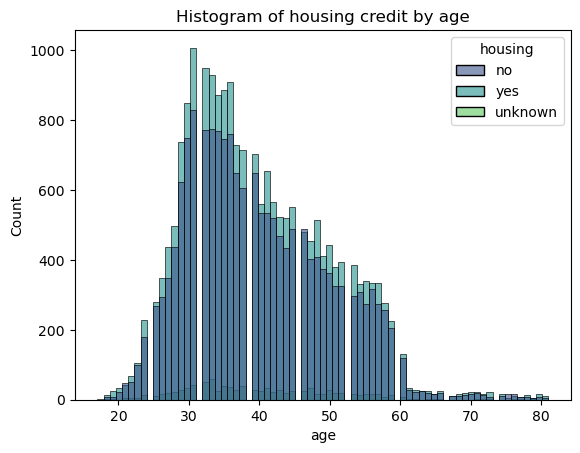

In [84]:
sns.histplot(data=data, x="age", hue="housing", palette="viridis", alpha=0.6)
plt.title("Histogram of housing credit by age")
plt.show()

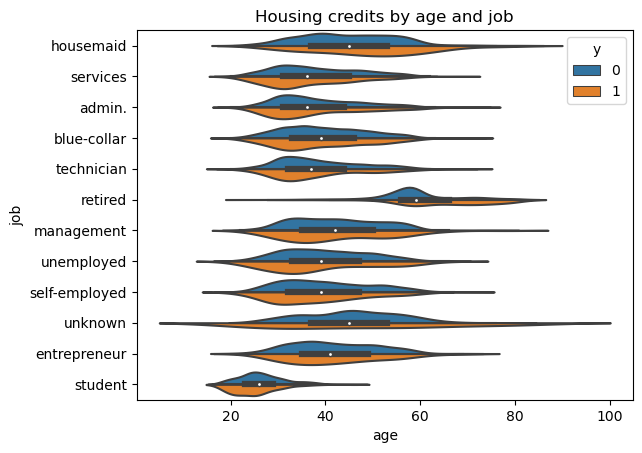

In [85]:
sns.violinplot(
    x="age",
    y="job",
    data=data[data['housing'] != 'unknown'],
    hue="y",
    split=True)
plt.title("Housing credits by age and job")
plt.show()

From this plot we can see that potentially best customers will be people between 30 and 40 years (except for housemaids and students).

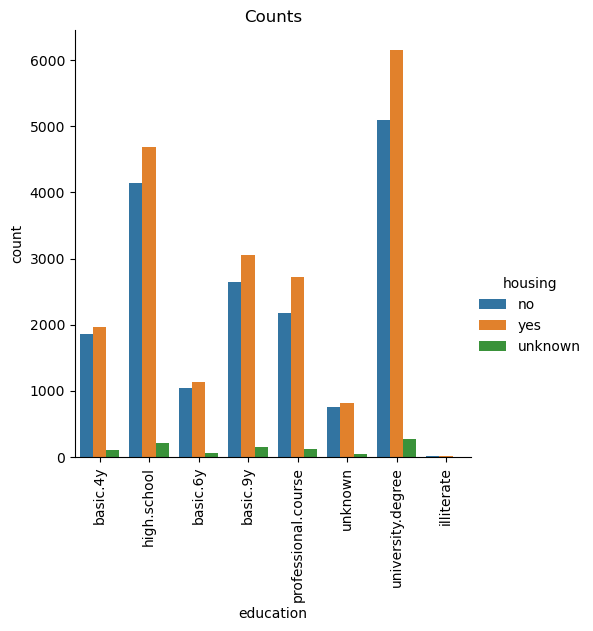

In [86]:
sns.catplot(x="education", kind="count", hue="housing", data=data)
plt.xticks(rotation=90)
plt.title("Counts")
plt.show()

There seems to be a slightly positive correlation betwen the level of education and probability that a person has a housing credit.

# Part 2: Data Preparation 

Here we will prepare data to dimensionality reduction step. We have already delt with outliers and deleted some of hopeless features and replace one numerical ('pdays') with categorical ('contacted').
<br>
<br>
We also took care of the outliers with the MAD algorithm.
<br>
<br>
Now we need to:
<br>
 - take care of missing values in categorical columns (marked as 'unknown' and 'nonexistent') 
<br>
 - preprare our data for dimensionality reduction (encode categorical values, scale numerical features)

In order to take care of those issues we will create Pipeline:
<br>
 - It normalizes and scales numerical features. This way we can significantly improve training process, especially in case of algorithms that rely on the magnitude of values like gradient descent-based algorithms and neural networks. because all features are now in the same scale. Downside of this approach is that it is sensitive to outliers as it works based on minimal and maximal values but we have already taken care of outliers. 
 - It imputes data in place of missing values in columns 'marital','loan','job','housing' based on the most frequent value in them. We chose such approach, because the number of missing values in them is not that big (less than 1000 from around 40000 rows).
 - It applies one-hot-encoding to categorical data what basically means that for each of categories represented in column we create new column with values 0 meaning that this row belongs to this category and 1 if it doesn't.

In [87]:
data.replace(['unknown', 'nonexistent'], np.nan, inplace=True)

In [88]:
def education_order(level):
    levels = np.array([ 'illiterate', 'basic.4y',  'basic.6y', 'basic.9y', 'high.school', 'university.degree', 'professional.course'])
    index = np.where(levels == level)[0]
    if len(index) > 0:
        return index.item()
    else:
        return np.nan

def default_encode(val):
    if val == 'yes':
        return 1
    elif val == 'no':
        return 0
    else: 
        return np.nan

data['education'] = data['education'].apply(education_order)
data['default']   = data['default'] .apply(default_encode)
data[['education','default']].head()

,education,default
0,1.0,0.0
1,4.0,NaN
2,4.0,0.0
3,2.0,0.0
4,4.0,0.0


In [140]:
numeric_transformer     = Pipeline([
#('normalizer', Normalizer()),
('std_scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocess_cat_cols = categorical_columns[(categorical_columns != 'education') & (categorical_columns != 'default') & (categorical_columns != 'contacted')]

preprocessor            = ColumnTransformer([
    ('numeric_preprocess', numeric_transformer, numerical_columns),
    ('categorical_preprocess', categorical_transformer, preprocess_cat_cols),#categorical_columns),
]  , remainder='passthrough')



In [141]:
transformed_data = preprocessor.fit_transform(data)#.drop(['education','default','contacted','y'], axis=1))

numeric_feature_names = numerical_columns
categorical_feature_names = preprocessor.named_transformers_['categorical_preprocess']\
    .named_steps['one_hot_encoder'].get_feature_names_out(input_features=preprocess_cat_cols)
categorical_feature_names = categorical_feature_names[~np.isin(categorical_feature_names, categorical_columns)]
#flattened_categorical_names = [f"{col}_{val}" for col, vals in zip(preprocess_cat_cols, categorical_feature_names)
#                               for val in vals]

#passthrough_feature_names = preprocessor.transformers_[-1][-1]
all_feature_names = np.concatenate((numeric_feature_names, categorical_feature_names))
#all_feature_names = all_feature_names[~np.isin(all_feature_names, categorical_columns)]
transformed_data = pd.DataFrame(transformed_data, columns=np.concatenate((all_feature_names, np.array(['contacted','education','default','y'])), axis=None))

transformed_data.head()

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,...,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,contacted,education,default,y
0,1.604013,-0.743789,-0.361998,0.631935,0.740658,0.907349,0.693602,0.301919,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.703475,-0.743789,-0.361998,0.631935,0.740658,0.907349,0.693602,0.301919,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,NaN,0.0
2,-0.285768,-0.743789,-0.361998,0.631935,0.740658,0.907349,0.693602,0.301919,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
3,0.012618,-0.743789,-0.361998,0.631935,0.740658,0.907349,0.693602,0.301919,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,1.604013,-0.743789,-0.361998,0.631935,0.740658,0.907349,0.693602,0.301919,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0


In [143]:
knn = KNNImputer(n_neighbors=5, weights='distance')

transformed_data[['education','default']] = knn.fit_transform(transformed_data[['education','default']])
transformed_data.head()

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,...,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,contacted,education,default,y
0,1.604013,-0.743789,-0.361998,0.631935,0.740658,0.907349,0.693602,0.301919,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.703475,-0.743789,-0.361998,0.631935,0.740658,0.907349,0.693602,0.301919,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
2,-0.285768,-0.743789,-0.361998,0.631935,0.740658,0.907349,0.693602,0.301919,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
3,0.012618,-0.743789,-0.361998,0.631935,0.740658,0.907349,0.693602,0.301919,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,1.604013,-0.743789,-0.361998,0.631935,0.740658,0.907349,0.693602,0.301919,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0


# Part 3: DR

## <p style="font-size:30px"> PCA </p> 
First well apply PCA to our data with 2 components

            PC1       PC2
0     -1.627118  3.105252
1     -1.380526  0.249501
2     -1.308075 -0.098289
3     -1.497020  1.862052
4     -1.377367  0.230125
...         ...       ...
39163  2.138627 -0.829103
39164  2.128838 -1.156371
39165  2.016652 -0.172615
39166  2.190184 -1.432795
39167  2.869815 -0.733433

[39168 rows x 2 columns]


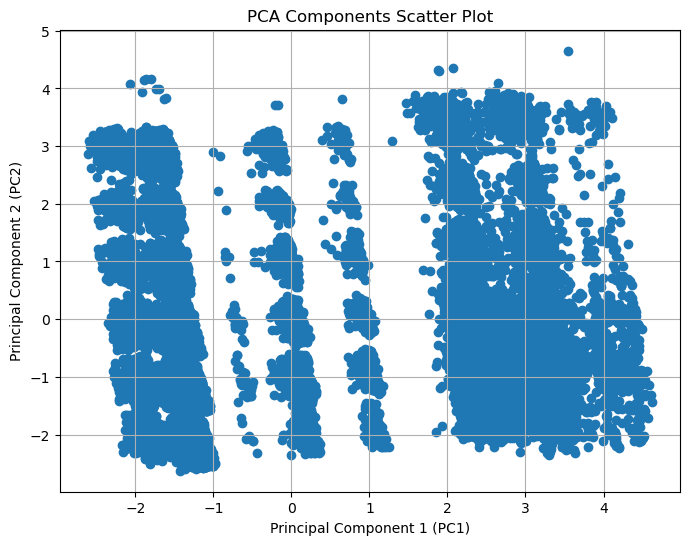

In [147]:
from sklearn.decomposition import PCA

pca2 = PCA(n_components=2)  # Specify the number of components
pca_result = pca2.fit_transform(transformed_data)

# Convert the result to a DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])  # Adjust column names as needed
print(pca_df)

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.title('PCA Components Scatter Plot')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.grid(True)
plt.show()

Lets plot eplained variance for this calculation.

Explained Variance Ratio:
[0.29390366 0.16978311]


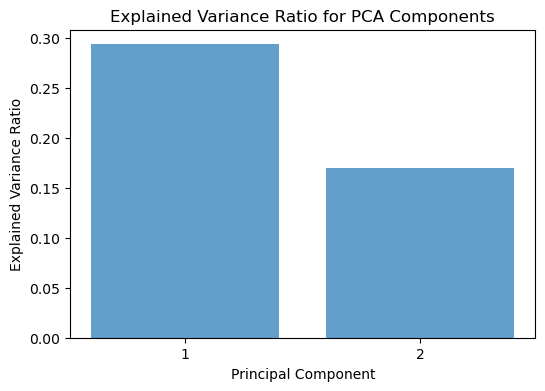

In [149]:
explained_variance_ratio = pca2.explained_variance_ratio_
print("Explained Variance Ratio:")
print(explained_variance_ratio)

# Plot explained variance ratio
plt.figure(figsize=(6, 4))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for PCA Components')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.show()

Now PCA for 3 components

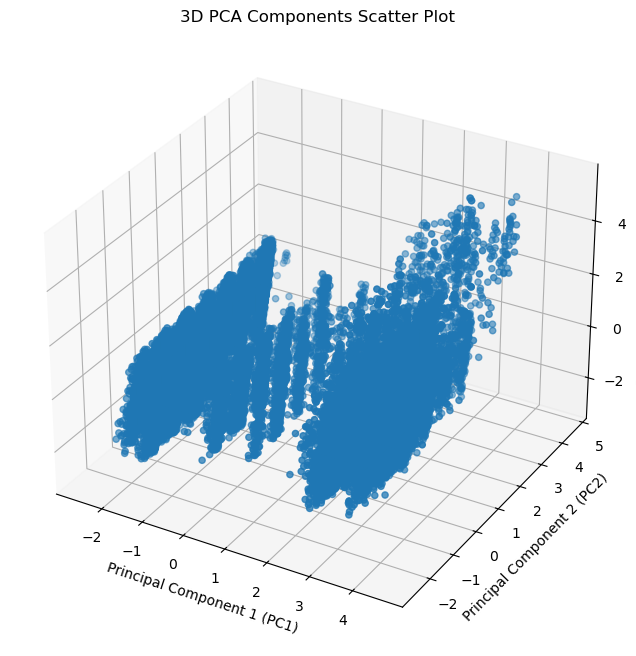

In [152]:
from mpl_toolkits.mplot3d import Axes3D

pca3 = PCA(n_components=3)
pca_result = pca3.fit_transform(transformed_data)

# Convert the result to a DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

# 3D scatter plot of PCA components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'])
ax.set_title('3D PCA Components Scatter Plot')
ax.set_xlabel('Principal Component 1 (PC1)')
ax.set_ylabel('Principal Component 2 (PC2)')
ax.set_zlabel('Principal Component 3 (PC3)')
plt.ion()
plt.show()

Explained Variance Ratio:
[0.29390366 0.16978311 0.08882851]


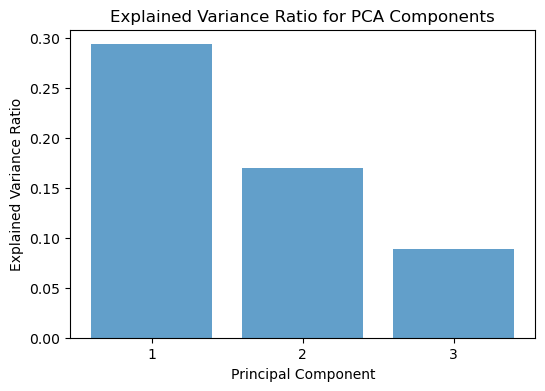

In [153]:
explained_variance_ratio = pca3.explained_variance_ratio_
print("Explained Variance Ratio:")
print(explained_variance_ratio)

# Plot explained variance ratio
plt.figure(figsize=(6, 4))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for PCA Components')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.show()

We can see that addin 3rd pca component explains additional 10% of variation in data.

In [157]:
for n in range(10):
    pca = PCA(n_components=n)
    pca_result = pca.fit_transform(transformed_data)
    print(n, ' components - variance explained ', pca.explained_variance_ratio_.sum())
    if pca.explained_variance_ratio_.sum() > 0.8:
        break
print('Optimal number of components: ', n)

0  components - variance explained  0.0
1  components - variance explained  0.2939036606747633
2  components - variance explained  0.4636867676764252
3  components - variance explained  0.5525152796263316
4  components - variance explained  0.626613262744628
5  components - variance explained  0.6914325048119854
6  components - variance explained  0.7483741087700537
7  components - variance explained  0.7926584112783749
8  components - variance explained  0.8171920858283276
Optimal number of components:  8


It makes sense to calculate PCA for up to 5 components. Further it doesnt bring much additional information and is much harder to read.

## t-SNE

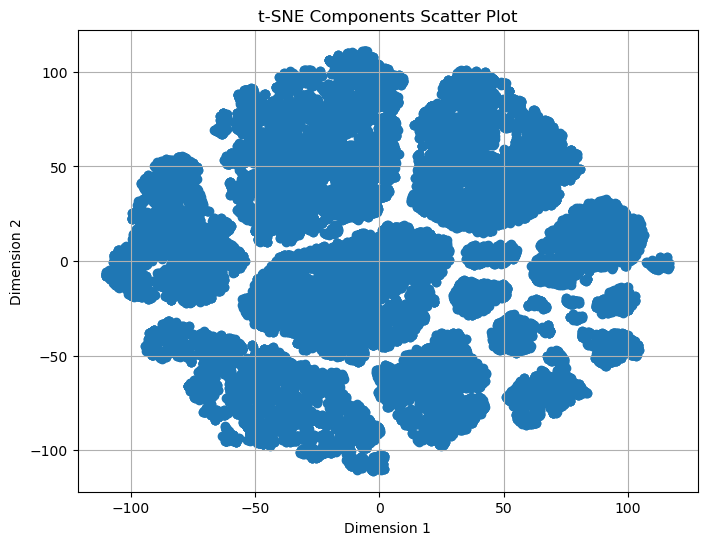

In [162]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(transformed_data)

# Convert the result to a DataFrame
tsne_df = pd.DataFrame(data=tsne_result, columns=['Dimension 1', 'Dimension 2'])

# Plot t-SNE components
plt.figure(figsize=(8, 6))
plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'])
plt.title('t-SNE Components Scatter Plot')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()